let's load the dependencies

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import mne
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import pearsonr
from sklearn.neighbors import NearestCentroid as NCC

In [2]:
def filter(data): # Pass sampling rate as an argument
    # median filter to remove artifacts
    # data = signal.medfilt(data, kernel_size=3) # Uncomment if needed

    # --- High-Pass Filter ---
    hpf_cutoff = 1  # Hz - Recommended for ERPs to remove slow drift
    hpf_order = 4     # Filter order (can be same or different from LPF)

    # Design Butterworth HPF
    # Note: fs/2 is the Nyquist frequency
    b_high, a_high = signal.butter(hpf_order, hpf_cutoff / 100, btype='high')

    # Apply HPF using zero-phase filtering
    # Apply along the time axis (assuming channels x time or trials x channels x time)
    data_hpf = signal.filtfilt(b_high, a_high, data, axis=-1)

    # --- Low-Pass Filter ---
    lpf_cutoff = 40.0  # Hz - Typical for ERPs
    lpf_order = 4      # Filter order

    # Design Butterworth LPF
    b_low, a_low = signal.butter(lpf_order, lpf_cutoff / 100, btype='low')

    # Apply LPF using zero-phase filtering to the high-passed data
    filtered_data = signal.filtfilt(b_low, a_low, data_hpf, axis=-1)

    return filtered_data

let us filter our time series, filter them, run ICA to get rid of the EOG components, and epoch them

In [3]:
eeg_channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
    'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
    'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
    'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7',
    'POz', 'P08', 'O1', 'O2']

eog_channel = 'EOG' 

all_channels = eeg_channels + [eog_channel]
all_labels = pd.read_csv('TrainLabels.csv').Prediction.values


In [4]:
try:
    all_epochs = np.load('all_epochs.npy')
except:
    all_epochs = [] # Store cleaned EEG epochs

    # --- Loop through sessions ---
    for filename in tqdm(os.listdir('train')):
        session_data = pd.read_csv(os.path.join('train', filename))

        # --- 1. Filter EEG and EOG Channels ---
        print(f"\nProcessing {filename}...")
        for id in all_channels:
            session_data[id] = filter(session_data[id].values)

        # --- 2. Prepare Continuous Data for ICA ---
        # Shape: (n_channels, n_timepoints)
        eeg_data = session_data[eeg_channels].values.T
        eog_data = session_data[eog_channel].values.reshape(1, -1) # Keep as 2D array

        # Transpose for sklearn: (n_timepoints, n_features)
        eeg_data_skl = eeg_data.T
        eog_data_skl = eog_data.T

        # --- 3. Standardize Data ---
        scaler_eeg = StandardScaler()
        eeg_data_scaled = scaler_eeg.fit_transform(eeg_data_skl)

        scaler_eog = StandardScaler()
        eog_data_scaled = scaler_eog.fit_transform(eog_data_skl) # Scale EOG separately

        # --- 4. Fit ICA on EEG Data ---
        n_components_ica = len(eeg_channels) # Use number of EEG channels as components
        ica = FastICA(n_components=n_components_ica,
                        random_state=42,
                        whiten='unit-variance', # Recommended for FastICA
                        max_iter=1000, # Increase iterations if convergence is an issue
                        tol=0.001)     # Convergence tolerance

        print("Fitting ICA...")
        sources_eeg = ica.fit_transform(eeg_data_scaled) # Shape: (n_timepoints, n_components_ica)
        print("ICA fitting complete.")

        # --- 5. Identify EOG Component(s) via Correlation ---
        print("Identifying EOG components...")
        correlations = []
        eog_signal_flat = eog_data_scaled.flatten() # Ensure EOG is 1D for correlation

        for i in range(sources_eeg.shape[1]):
            component_signal = sources_eeg[:, i]
            # Calculate Pearson correlation coefficient and p-value
            corr, _ = pearsonr(eog_signal_flat, component_signal)
            correlations.append(abs(corr)) # Use absolute correlation

            eog_component_index = np.argmax(correlations)
            max_corr = correlations[eog_component_index]

            print(f"Removing component {eog_component_index} with correlation: {max_corr:.4f}")
            sources_cleaned = sources_eeg.copy()
            sources_cleaned[:, eog_component_index] = 0

        # --- 7. Reconstruct Cleaned EEG Data ---
        print("Reconstructing cleaned EEG data...")
        # Use inverse_transform to go from sources back to sensor space
        eeg_data_cleaned_scaled = ica.inverse_transform(sources_cleaned)

        # --- 8. Un-standardize Cleaned EEG Data ---
        eeg_data_cleaned_unscaled = scaler_eeg.inverse_transform(eeg_data_cleaned_scaled)

        # Prepare cleaned data for epoching (back to DataFrame structure)
        eeg_data_to_epoch = pd.DataFrame(eeg_data_cleaned_unscaled, columns=eeg_channels, index=session_data.index)
        print("EEG data cleaned.")


        # --- 9. Epoching
        session_feedback_ids = session_data[session_data['FeedBackEvent'] == 1].index
        session_epochs = []
        print(f"Epoching {len(session_feedback_ids)} events...")
        for idx in session_feedback_ids:
            # Define epoch window relative to event index
            start_idx = idx - 40  # 200ms before (40 samples at 200Hz)
            end_idx = idx + 199 # 1000ms after (200 samples at 200Hz) -> inclusive index for .loc

            # Define baseline window relative to event index
            baseline_start_idx = idx - 40 # 200ms before
            baseline_end_idx = idx      # Up to (but not including) the event

            # Extract epoch data for EEG channels
            epoch_data = eeg_data_to_epoch.loc[start_idx:end_idx].copy()

            # Calculate baseline using the correct window from the *epoched* data
            baseline_data = epoch_data.loc[baseline_start_idx:baseline_end_idx]
            baseline_mean = baseline_data.mean(axis=0)

            # Apply baseline correction
            epoch_data -= baseline_mean

            # Append the baseline-corrected epoch (EEG channels only)
            session_epochs.append(epoch_data.values) # Append numpy array

        all_epochs.extend(session_epochs) # Add the cleaned epochs to the list
        print(f"Finished {filename}. Total epochs collected: {len(all_epochs)}")


    # --- Convert cleaned epochs to NumPy array ---
    # Shape: (n_epochs, n_timepoints_in_epoch, n_eeg_channels)
    all_epochs = np.array(all_epochs)
    print(f"Final shape of cleaned epochs array: {all_epochs.shape}")

let's now collapse the epochs into subsequent 25ms time windows and calculate the ROC score for each window and channel

In [5]:
channel_to_roc = {}

for id, channel in tqdm(enumerate(eeg_channels)):
    channel_data = [epoch[:, id] for epoch in all_epochs]
    channel_data = np.array(channel_data)
    rocs = []
    
    for time_point in range(0, 240, 5):
        time_window_data = channel_data[:, time_point:time_point+5].mean(axis=1) # average voltage over 5 time points (25ms)
        rocs.append(roc_auc_score(all_labels, time_window_data)) # calculate AUC for the time window
    
    channel_to_roc[channel] = rocs

56it [00:04, 12.35it/s]


display the ROC scores as a heatmap

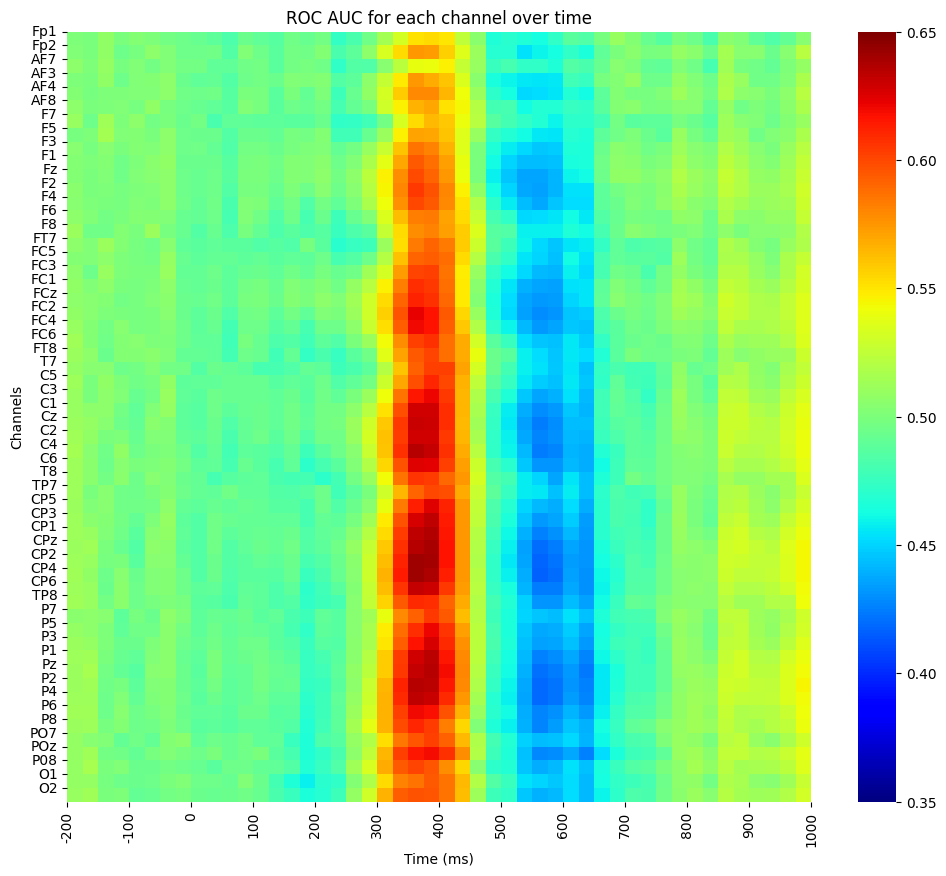

In [6]:
arr = np.array([channel_to_roc[channel] for channel in eeg_channels])
plt.figure(figsize=(12, 10))
sns.heatmap(arr, cmap='jet', vmin=0.35, vmax=0.65)
plt.xticks(np.arange(0, 52, 4), np.arange(-200, 1100, 100), rotation=90)
plt.yticks(np.arange(0, len(eeg_channels)), eeg_channels, rotation=0)
plt.xlabel('Time (ms)')
plt.ylabel('Channels')
plt.title('ROC AUC for each channel over time')
plt.show()

Among others, the interval around 300-450 ms looks interesting.

Let's look at the topographies of the ROC scores for each of the time windows

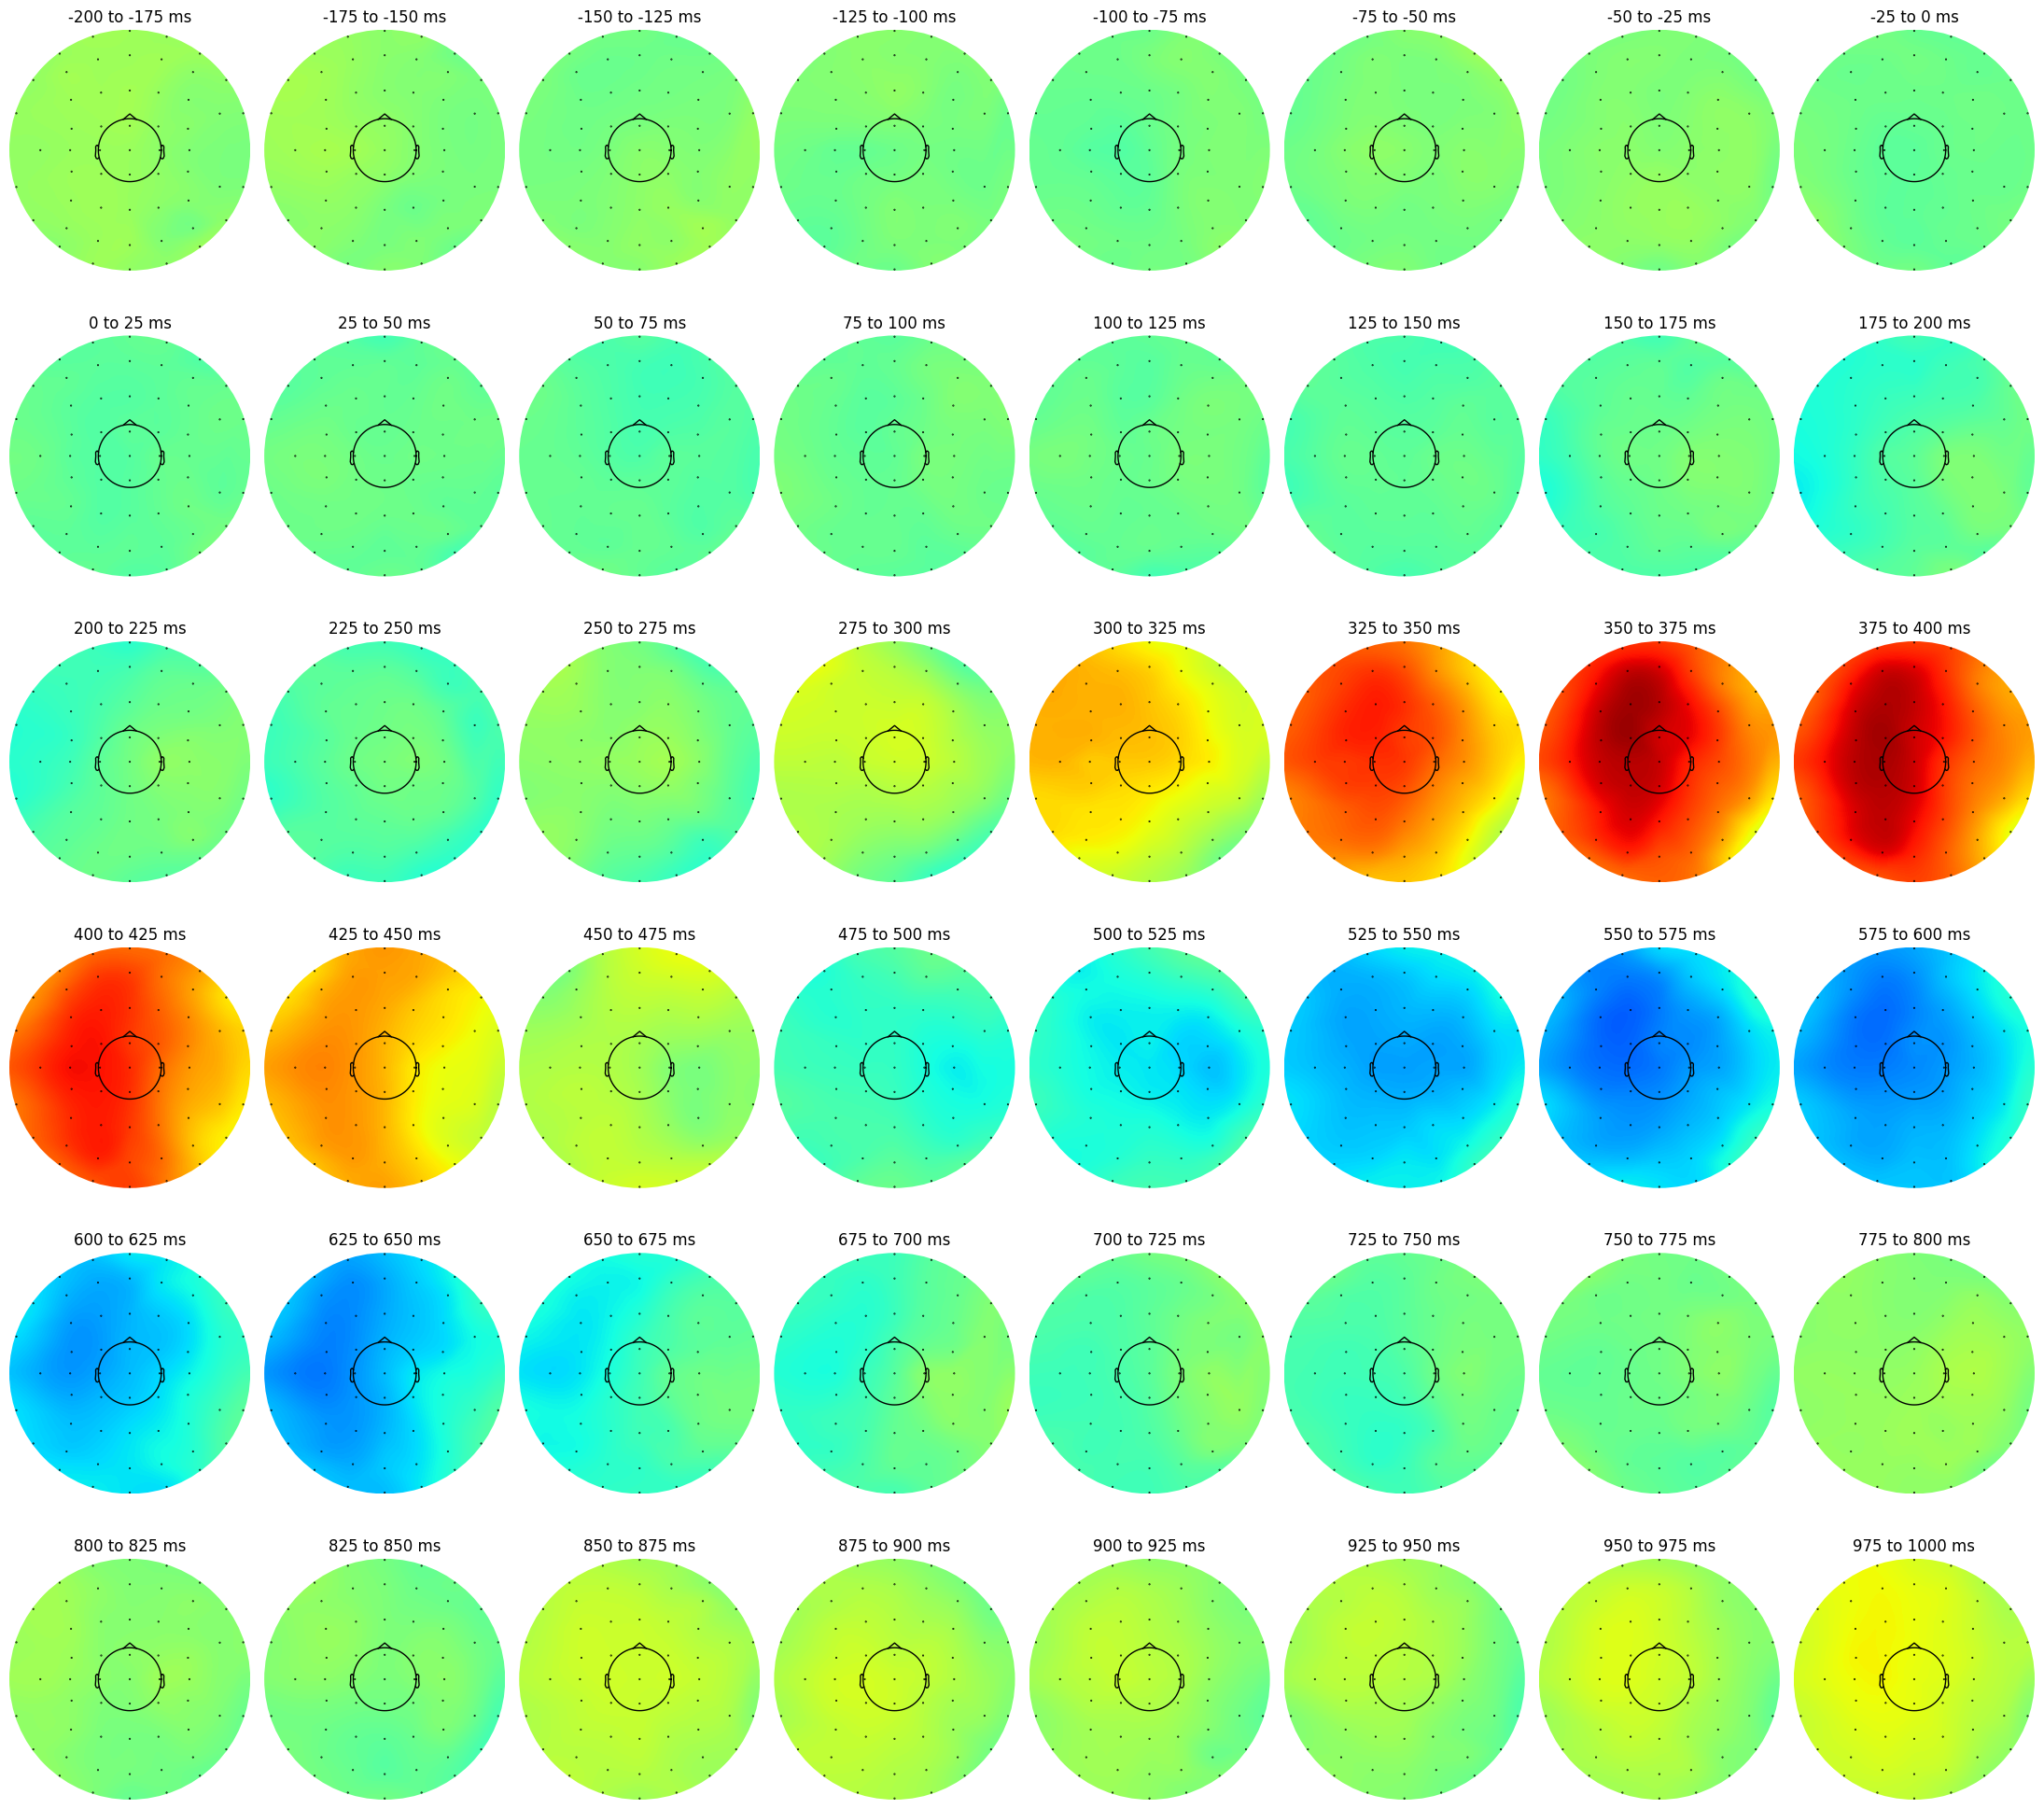

In [7]:
# Load CSV
df = pd.read_csv("ChannelsLocation.csv")

# Convert spherical (Radius, Phi) -> Cartesian (X, Y, Z)
df["Phi"] = np.deg2rad(df["Phi"])  # Convert degrees to radians
df["X"] = df["Radius"] * np.cos(df["Phi"])
df["Y"] = df["Radius"] * np.sin(df["Phi"])
df["Z"] = np.zeros(len(df))  # Assume all electrodes lie on a 2D plane

# Create Montage
ch_pos = {row["Labels"]: [row["X"], row["Y"], row["Z"]] for _, row in df.iterrows()}
montage = mne.channels.make_dig_montage(ch_pos, coord_frame="head")

# Create info object
ch_names = list(df["Labels"])
info = mne.create_info(ch_names, sfreq=200, ch_types="eeg")
info.set_montage(montage)

# Example: Plot Topomap with Random Data
f, ax = plt.subplots(6, 8, figsize=(22, 20))
ax = ax.ravel()

for i in range(0, 48):
    ax[i].set_title(f"{(i - 8)*25} to {(i - 7)*25} ms")
    mne.viz.plot_topomap(arr[:, i], info, size=3, cmap="jet", vlim=(0.35, 0.65), 
                        show=False, outlines="head", axes=ax[i], contours=False)

plt.tight_layout()
plt.show()


Based on the topographies, we can proceed with the intervals from 300 ms to 450 ms.

Having identified the time intervals, let's prepare our dataset

In [71]:
X = []
features = [f"average {channel} voltage from {time_point * 5 - 200} to {time_point * 5 - 175} ms" for channel in eeg_channels for time_point in range(100, 130, 5)]

for id in tqdm(range(len(eeg_channels))):
    channel_data = [epoch[:, id] for epoch in all_epochs]
    channel_data = np.array(channel_data)
    for time_point in range(100, 130, 5):
        time_window_data = channel_data[:, time_point:time_point+5].mean(axis=1) # average voltage over 5 time points (25ms)
        X.append(time_window_data) # append the time window data to the list of all epochs in the session

X = np.array(X).T # Transpose to get shape (n_samples, n_features)
# X_train, X_test, y_train, y_test = train_test_split(X, all_labels, test_size=0.2, random_state=42)

100%|██████████| 56/56 [-1:59:43<00:00, -3.22it/s]


In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Step 1: Combine features and labels
df = pd.DataFrame(X)
df['label'] = all_labels

# Step 2: Separate majority and minority classes
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Step 3: Undersample class 1
class_1_downsampled = resample(class_1,
                               replace=False,
                               n_samples=len(class_0),
                               random_state=42)

# Step 4: Combine and shuffle
balanced_df = pd.concat([class_0, class_1_downsampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 5: Split into features and labels
X_balanced = balanced_df.drop('label', axis=1).values
y_balanced = balanced_df['label'].values

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Done!
print("Class distribution after balancing:", np.bincount(y_balanced))
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Class distribution after balancing: [1590 1590]
Training set shape: (2544, 336)
Test set shape: (636, 336)


In [65]:
X, y = undersample_majority_class(X, all_labels)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now we can run PCA on the training set

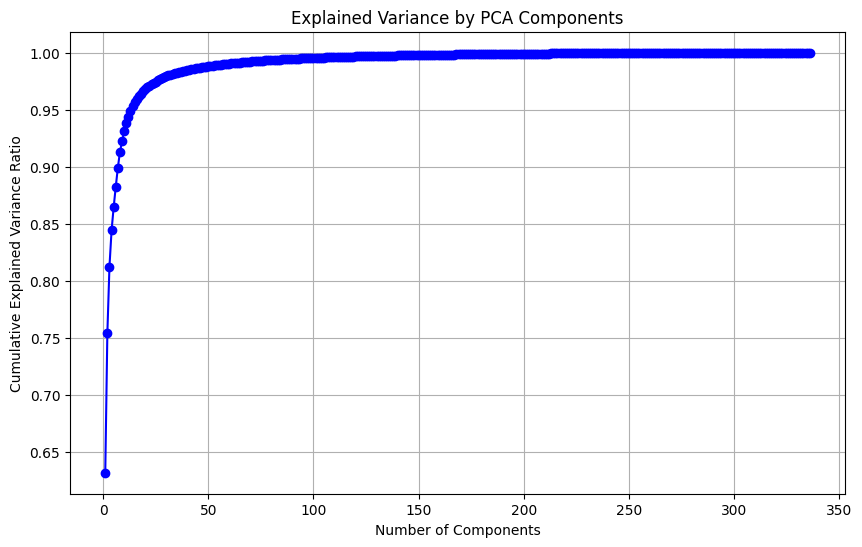

Number of components to explain variance:
90.0% variance: 8 components
95.0% variance: 14 components
97.5% variance: 26 components
99.0% variance: 58 components
99.9% variance: 193 components


In [73]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Determine number of components for different variance thresholds
variance_thresholds = [0.90, 0.95, 0.975, 0.99, 0.999]
components_for_thresholds = {
    threshold: np.argmax(cumulative_variance_ratio >= threshold) + 1 
    for threshold in variance_thresholds
}

print("Number of components to explain variance:")
for threshold, num_components in components_for_thresholds.items():
    print(f"{threshold*100}% variance: {num_components} components")

In [38]:
import numpy as np
from sklearn.utils import resample

def undersample_majority_class(X_train, y_train):
    # Separate majority and minority classes
    X_majority = X_train[y_train == 1]
    y_majority = y_train[y_train == 1]
    
    X_minority = X_train[y_train == 0]
    y_minority = y_train[y_train == 0]
    
    # Get the number of samples in minority class
    n_minority = len(X_minority)
    
    # Undersample majority class
    X_majority_undersampled = resample(
        X_majority,
        replace=False,  # sample without replacement
        n_samples=n_minority,  # match minority class
        random_state=42  # reproducible results
    )
    y_majority_undersampled = resample(
        y_majority,
        replace=False,
        n_samples=n_minority,
        random_state=42
    )
    
    # Combine minority class with undersampled majority class
    X_balanced = np.vstack((X_majority_undersampled, X_minority))
    y_balanced = np.hstack((y_majority_undersampled, y_minority))
    
    # Shuffle the data
    indices = np.arange(len(X_balanced))
    np.random.shuffle(indices)
    X_balanced = X_balanced[indices]
    y_balanced = y_balanced[indices]
    
    return X_balanced, y_balanced

In [68]:
X_train_pca.shape, y_train.shape

((2544, 336), (2544,))

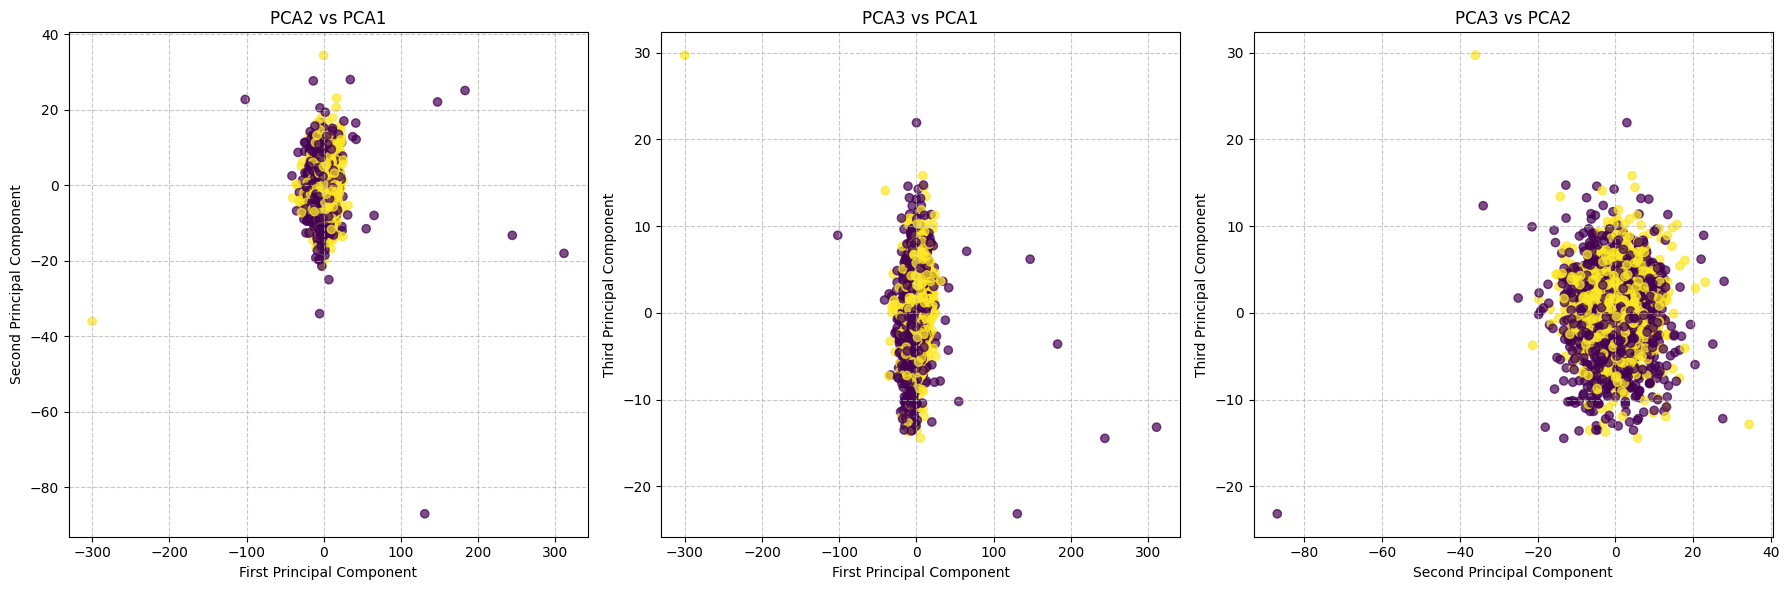

Variance explained by first 3 principal components:
PC1: 0.6318 (63.18%)
PC2: 0.1224 (12.24%)
PC3: 0.0584 (5.84%)
Total: 0.8126 (81.26%)


In [74]:
# Create a figure with 3 subplots for PCA visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot PCA2 vs PCA1
scatter1 = axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('PCA2 vs PCA1')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot PCA3 vs PCA1
scatter2 = axes[1].scatter(X_train_pca[:, 0], X_train_pca[:, 2], c=y_train, cmap='viridis', alpha=0.7)
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Third Principal Component')
axes[1].set_title('PCA3 vs PCA1')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot PCA3 vs PCA2
scatter3 = axes[2].scatter(X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis', alpha=0.7)
axes[2].set_xlabel('Second Principal Component')
axes[2].set_ylabel('Third Principal Component')
axes[2].set_title('PCA3 vs PCA2')
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Display variance explained by the first three components
print(f"Variance explained by first 3 principal components:")
print(f"PC1: {explained_variance_ratio[0]:.4f} ({explained_variance_ratio[0]*100:.2f}%)")
print(f"PC2: {explained_variance_ratio[1]:.4f} ({explained_variance_ratio[1]*100:.2f}%)")
print(f"PC3: {explained_variance_ratio[2]:.4f} ({explained_variance_ratio[2]*100:.2f}%)")
print(f"Total: {sum(explained_variance_ratio[:3]):.4f} ({sum(explained_variance_ratio[:3])*100:.2f}%)")

## LDA

The PCA features allow us to fit an LDA model on this dataset

In [17]:
X_train_pca, y_train = undersample_majority_class(X_train_pca, y_train)

In [ ]:
X_train_pca[:, :16]

(2574, 16)

LDA Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       335
           1       0.63      0.64      0.64       301

    accuracy                           0.65       636
   macro avg       0.65      0.65      0.65       636
weighted avg       0.65      0.65      0.65       636



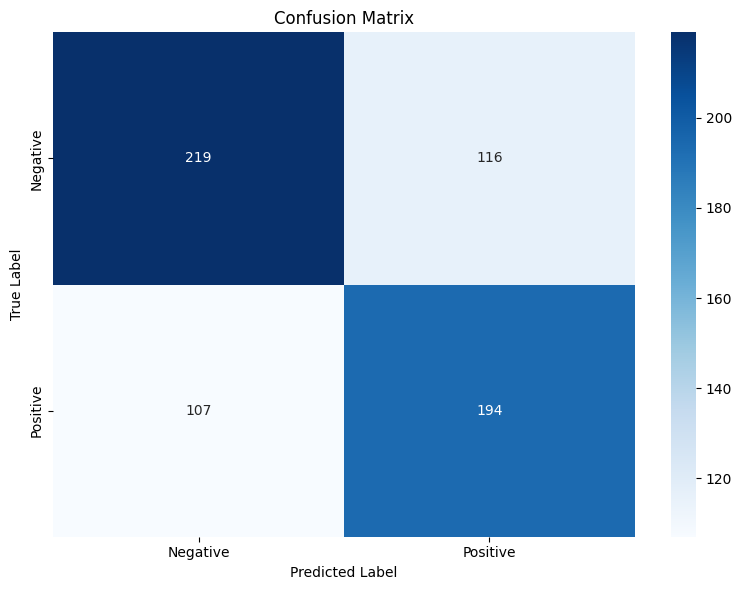

ROC AUC Score: 0.6491


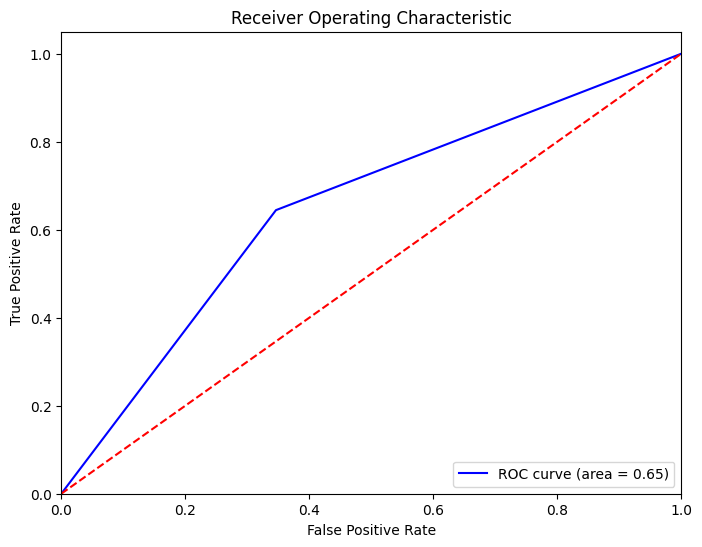

In [75]:
# Create an LDA model
lda = LDA()
lda.fit(X_train_pca, y_train)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
y_pred_lda = lda.predict(X_test_pca)

# Print metrics
print("LDA Classification Report:")
print(classification_report(y_test, y_pred_lda))

# Create confusion matrix display
conf_matrix = confusion_matrix(y_test, y_pred_lda)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC AUC for LDA:
roc_auc_score_value = roc_auc_score(y_test, y_pred_lda)
print(f"ROC AUC Score: {roc_auc_score_value:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lda)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_score_value)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

LDA Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.64      0.66       335
           1       0.62      0.65      0.64       301

    accuracy                           0.65       636
   macro avg       0.65      0.65      0.65       636
weighted avg       0.65      0.65      0.65       636



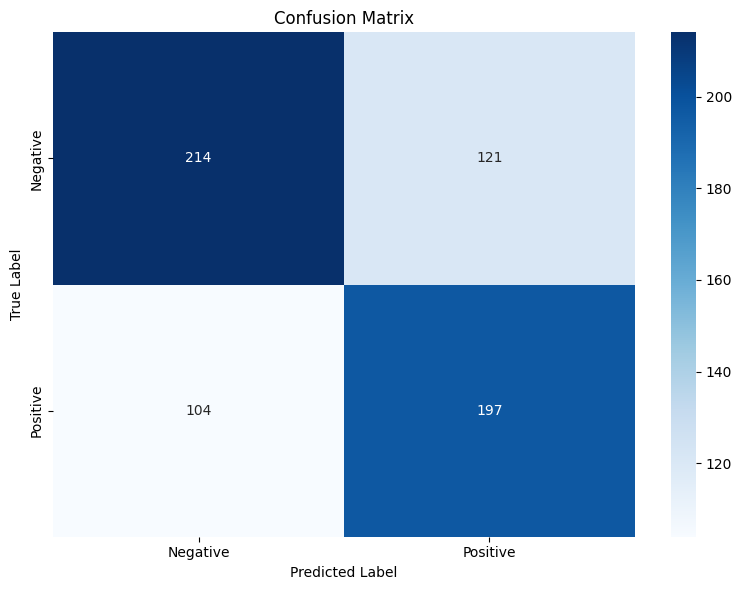

ROC AUC Score: 0.6466


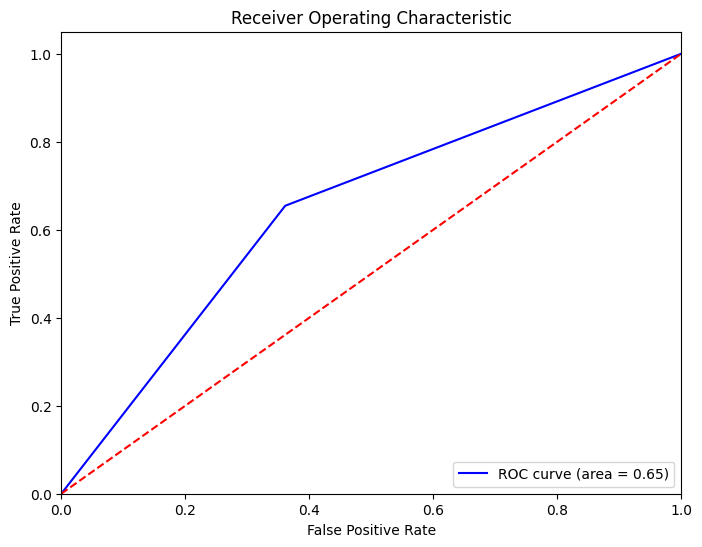

In [77]:
# Create an LDA model
rlda = LDA(solver='lsqr', shrinkage=0.5)
rlda.fit(X_train_pca, y_train)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
y_pred_lda = rlda.predict(X_test_pca)

# Print metrics
print("LDA Classification Report:")
print(classification_report(y_test, y_pred_lda))

# Create confusion matrix display
conf_matrix = confusion_matrix(y_test, y_pred_lda)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC AUC for LDA:
roc_auc_score_value = roc_auc_score(y_test, y_pred_lda)
print(f"ROC AUC Score: {roc_auc_score_value:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lda)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_score_value)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [81]:
all_labels.sum() / len(all_labels) # 0.5

np.float64(0.7077205882352942)

NCC

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.60      0.45       303
           1       0.79      0.59      0.67       785

    accuracy                           0.59      1088
   macro avg       0.58      0.59      0.56      1088
weighted avg       0.67      0.59      0.61      1088



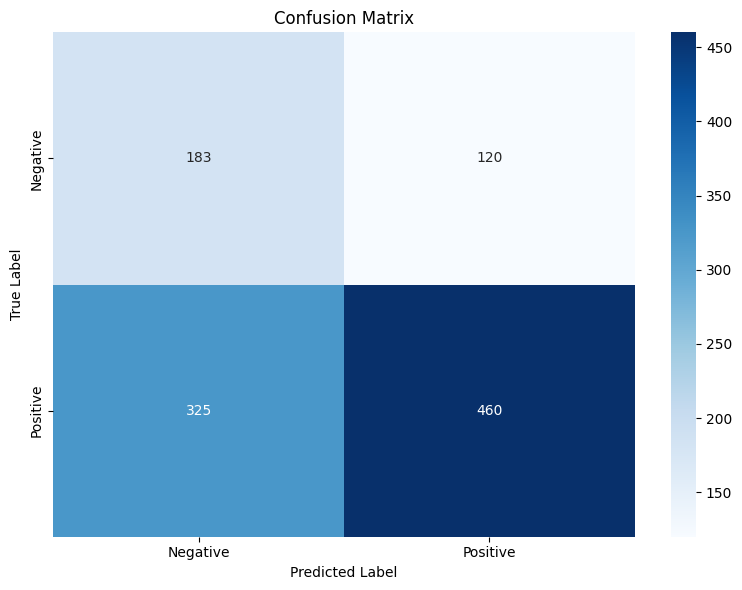

In [53]:
# Let's fit an NCC model

ncc = NCC()
ncc.fit(X_train_pca[:, :15], y_train)
y_pred_lr = ncc.predict(X_test_pca[:, :15])

print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

conf_matrix_ncc = confusion_matrix(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.63      0.51       303
           1       0.82      0.68      0.74       785

    accuracy                           0.66      1088
   macro avg       0.63      0.65      0.63      1088
weighted avg       0.71      0.66      0.68      1088



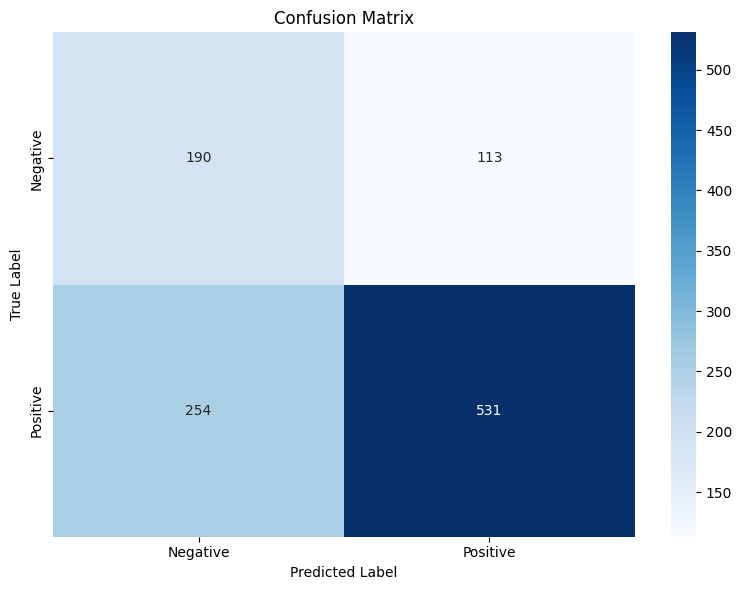

In [59]:
# Let's fit a logistic regression model
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_curve

ncc = LR(solver='liblinear')
ncc.fit(X_train_pca, y_train)
y_pred_lr = ncc.predict(X_test_pca)

print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

conf_matrix_ncc = confusion_matrix(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()